# D213 Task 2 - Sentiment Analysis

# Western Governors University

# Lucas Benish


---



# Part 1: Research Question

## A. Describe the purpose of this data analysis by doing the following

### 1.	Summarize one research question that you will answer using neural network models and NLP techniques. Be sure the research questions is relevant to a real-world organizational situation and sentiment analysis captured in your chosen dataset.

One research question that I will seek to answer throughout this analysis is as follows: utilizing an initial dataset of 3000  reviews from varying sites, can we create a predictive model to predict the sentiments of our customers' reviews?

### 2.	Define the objectives or goals of the data analysis. Be sure that your objectives or goals are reasonable within the scope of the scenario and is represented in the available data.

The overall goal of this data analysis is to create a predictive model utilizing a neural network that will predict whether a user's review contains a positive or negative sentiment of the product/service. This is reasonable within the scope of this task, as the UCI sentiment data set contains 500 positive and 500 negative reviews, with a binary classifier for positive or negative sentiment, from 3 different sources. This totals 3000 reviews with 1500 positive and 1500 negative.

### 3.	Identify a type of neural network capable of performing a text classification task that can be trained to produce useful predictions on text sequences on the selected data set.

The type of neural network that will be utilized for this text classification will be an recurrent neural network (RNN) (Elleh, 2022). This type of neural network is the best choice for this sentiment analysis due to dependent nature of language, i.e. the sequencing of words. The hidden layers feature a "looping constraint" that allows for backwards propagation of information, rather than solely allowing data to move forwards from one layer to the next (Pai, 2023).

# Part 2: Data Preparation

## B.	Summarize the data cleaning process by doing the following:

### 1.	Perform exploratory data analysis on the chosen dataset, and include an explanation of each of the following elements:

Setting up environment

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import re
import string
import tensorflow as tf
import keras
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

Importing data frames

In [2]:
amazon_df = pd.read_csv('/amazon_cells_labelled.txt', sep='\t', names=['review', 'sentiment'])
imdb_df = pd.read_csv('/imdb_labelled.txt', sep='\t', names=['review', 'sentiment'])
yelp_df = pd.read_csv('/yelp_labelled.txt', sep='\t', names=['review', 'sentiment'])

df_object = [amazon_df, imdb_df, yelp_df]

sentiment_df = pd.concat(df_object, ignore_index=True)
sentiment_df.head()
#adapted from Elleh, 2022


,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


Initial exploration

In [3]:
print(sentiment_df.shape)
print(sentiment_df.isna().sum())
sentiment_df['review'] = sentiment_df['review'].str.lower()

print(sentiment_df['sentiment'].value_counts())


(3000, 2)
review       0
sentiment    0
dtype: int64
0    1500
1    1500
Name: sentiment, dtype: int64


Continued exploration, addressing bullet points from B1:
*   Presence of unusual characters (e.g. emojis, non-English characters, etc.)
*   Vocabulary size
*   Proposed wors embedding length
*   Statistical justification for the chosen maximum sequence length

In [139]:
#presence of unusual characters
reviews = sentiment_df['review'].to_string(index=False)
string.punctuation
#!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ #output from above line
non_standard_chars = re.findall('[!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]', reviews)
#\ entered into list to "escape" the ' within the list
print("There are", len(non_standard_chars), "non-alphanumeric characters within the initial data.")

There are 8348 non-alphanumeric characters within the initial data.


In [143]:
#determining "proposed" vocabulary length
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True)
tokenizer.fit_on_texts(sentiment_df['review'])
sequenced_reviews = tokenizer.texts_to_sequences(sentiment_df['review'])
word_count = tokenizer.word_counts
proposed_vocabulary_size = len(word_count)

print("The proposed vocabulary size is:", proposed_vocabulary_size)

The proposed vocabulary size is 5271


In [146]:
#determining "proposed" embedding length
proposed_embed_length = int(round((proposed_vocabulary_size**0.5)**0.5))
print("The proposed embedding length is:", proposed_embed_length)

The proposed embedding length is: 9


In [151]:
#lengths of initial reviews
all_review_lengths = sentiment_df['review'].str.len()

print("The longest review is:", max(all_review_lengths), "characters long.")
print("The shortest review is:", min(all_review_lengths), "characters long.")

#proposed maximum sequence length
max_review_length = max(len(review) for review in sequenced_reviews)
min_review_length = min(len(review) for review in sequenced_reviews)

print("The longest review is:", max_review_length, "words long.")
print("The shortest review is:", min_review_length, "word long.")

The longest review is: 479 characters long.
The shortest review is: 7 characters long.
The longest review is: 73 words long.
The shortest review is: 1 word long.


The above code segments demonstrate the initial/"proposed" values for various model variable needs during an initial exploration of the dataset. It can be seen that within the initial dataset, there are over 8000 non-alphanumeric values. These characters will not provide any benefit in the analysis and will be removed during the cleaning process. The initial/"proposed" vocabulary size is determined to be 5271 following tokenization and sequencing. The "proposed" embedding length was determined by taking the square root of the square root of the vocabulary size (Elleh, 2022). Finally, the longest review was 479 characters, and 73 words, long. This value would be determined to be our "proposed" maximum length with regards to padding. Padding ensures that each of our inputs are of the same length for our model. Truncating would be another means of ensuring our inputs are all the same length, however as we have already discovered the maximum length of a sequence, we can set that to be our max length (TowardsDataScience, 2020).

Cleaning/pre-processing

In [148]:
#creating a new column without punctuation or stop words
#nltk.download('stopwords')
stop_words = stopwords.words('english')

def removing_punct(text):
  removed_punct = "".join(n for n in text if n not in ("?", ".", ";", ":",  "!",'"', ",", "'",
                                                '-', ')', '(', '/', '&', '*', '+', '#', '[', ']'))
  return removed_punct


sentiment_df['new_review'] = sentiment_df['review'].apply(removing_punct)
sentiment_df.head()

sentiment_df['new_review'] = sentiment_df['new_review'].apply(lambda x: ' '.join(word for word in x.split() if word not in (stop_words)))
sentiment_df.head()

#adapted from TowardsDataScience (2019)


,review,sentiment,new_review
0,so there is no way for me to plug it in here i...,0,way plug us unless go converter
1,"good case, excellent value.",1,good case excellent value
2,great for the jawbone.,1,great jawbone
3,tied to charger for conversations lasting more...,0,tied charger conversations lasting 45 minutesm...
4,the mic is great.,1,mic great


In [149]:
#defining new objects
new_reviews = sentiment_df['new_review'].values
sentiments = sentiment_df['sentiment'].values

#nltk.download('punkt')
#nltk.download('wordnet')

#lemmatizing the words/tokens
Lemma = nltk.WordNetLemmatizer()
Tokens = [word_tokenize(review) for review in new_reviews]

Lemmad_tokens = [[Lemma.lemmatize(word) for word in sentence] for sentence in Tokens]
new_reviews = np.asarray(Lemmad_tokens, dtype=object)
new_reviews[0:4]



array([list(['way', 'plug', 'u', 'unless', 'go', 'converter']),
       list(['good', 'case', 'excellent', 'value']),
       list(['great', 'jawbone']),
       list(['tied', 'charger', 'conversation', 'lasting', '45', 'minutesmajor', 'problem'])],
      dtype=object)

In [48]:
#tokenizing updated column/reviews

tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True)
tokenizer.fit_on_texts(new_reviews)

token_counts = tokenizer.word_counts
vocabulary_size = len(token_counts)+1


max_review = max(len(n) for n in new_reviews)
min_review = min(len(n) for n in new_reviews)

print("The vocabulary size is:", vocabulary_size)
print("The longest 'new_review' is:", max_review)
print("The shortest 'new_review' is:", min_review)


The vocabulary size is: 4867
The longest 'new_review' is: 41
The shortest 'new_review' is: 1


### 2.	Describe the goals of the tokenization process, including any code generated and packages that are used to normalize text during the tokenization process.

Tokenization was utilized above while determining the "proposed" and actual vocabulary lengths and embedding lengths, and will be utilized in a moment to create smaller text chunks. The goal of tokenization is just that, to create smaller chunks of text from an initial large body of text (Elleh, 2022). Tokenization can parse text from paragraphs/chapters down to sentences, words, and even to characters. Furthermore, during the process of splitting the text into smaller, computer-friendly chunks, some data preparation/cleaning can take place such as removing non-alphanumeric characters and stemming tokens to their root (Elleh, 2022). An example of tokenization will be pasted here, from the upcoming cell where the data is split into training and testing data.

Tokenize training reviews
<br>tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True, num_words=vocabulary_size, oov_token=oov_token)
<br>tokenizer.fit_on_texts(X_train)

Put tokens into index-based sequences
<br>unpad_train_reviews = tokenizer.texts_to_sequences(X_train)

Preparing the data to be modeled

In [70]:
#preparing additional variables for tokenizing/padding
embed_length = (vocabulary_size**0.5)**0.5
embed_dimension = int(round(embed_length))
oov_token = '<OOV>'
padding_type = 'post'


In [32]:
#split my data into training and testing
X_train, X_test, y_train, y_test = train_test_split(new_reviews, sentiments, test_size = 0.2, random_state=42)

In [33]:
# Tokenize training reviews
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True, num_words=vocabulary_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

# put tokens into index-based sequences
unpad_train_reviews = tokenizer.texts_to_sequences(X_train)

# pad reviews
train_reviews = tf.keras.preprocessing.sequence.pad_sequences(unpad_train_reviews, maxlen=max_review, padding=padding_type)

# repeat with testing set
unpad_test_reviews = tokenizer.texts_to_sequences(X_test)
test_reviews = tf.keras.preprocessing.sequence.pad_sequences(unpad_test_reviews, maxlen=max_review, padding=padding_type)

# put sentinment into array
train_labels = np.array(y_train)
test_labels = np.array(y_test)

### 3.	Explain the padding process used to standardize the length of sequences, including the following in your explanation:

*   If the padding occurs before or after the text sequence
*   A screenshot of a single padded sequence

In [155]:
#single example of padded train_reviews
train_reviews[1]

array([  20,    6,  109,  520, 1724,  267, 1095, 1725, 1726, 1727,  796,
       1728, 1096,  380,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

The above cell outputs a single row of the train_reviews array. It can be seen that it is an array made up of 41 values, some of which are non-zero and others that are zero. The non-zero values represent tokens/lemmatized text from prior steps. The values that contain zeros do not represent any specific text but have been added to increase the length of each array to the "max_review" length from above. This process is necessary to ensure that all tensor inputs are of the same shape and size, a requirement for our neyral network model (TowardsDataScience, 2020).

The cell that is two cells above demonstrates how the padding took place. Padding was utilized "post"-sequence, meaning that the zeroes were added to the end of the numeric sequence.

### 4.	Identify how many categories of sentiment will be used and an activation function for the final dense layer of the network.

It is seen in part B1, from the call of <br>"print(sentiment_df['sentiment'].valuecounts()," <br>that there are only two sentiments: 0 and 1. It is visible within the initial exploration that 0 represents a negative sentiment while 1 represents a positive sentiment. The goal of this model is to output either a 0 or 1, for negative and positive sentiment, respectively. Therefore, we need to utilize a final dense layer that will output a binary value. The activation function for this final layer will therefore be 'sigmoid.' This will be seen in a future cell, but the code will be pasted here for clarification:

model = tf.keras.Sequential()
<br>model.add(tf.keras.layers.Embedding(input_dim=vocabulary_size,
                           output_dim = embed_dimension,
                           input_length=max_review))
<br>model.add(tf.keras.layers.GlobalAveragePooling1D())
<br>model.add(tf.keras.layers.Dense(6, activation='relu'))
<br>model.add(tf.keras.layers.Dense(3, activation='relu'))
<br>model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
<br>model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
<br>model.summary()

### 5.	Explain the steps used to prepare the data for analysis, including the size of the training, validation, and test set split.

The steps that were utilized to prepare the data for analysis can be seen thus far. They will be summarized below:


1.   Import the data files utilizing pandas, concatenate them into a single file
2.   Explore the data
3.   Determine presence of nulls, duplicates, non-alphanumeric characters
4.   Clean data: remove nullls (none), remove non-alphanumeric characters, remove stopwords, lemmatize words to bring them down to just their roots
5.   Determine new model parameters/variables, such as vocabulary length, embedding length, maximum sequence length
6.   Split data into training/testing data sets, 80/20 split utilized; no validation split utilized
7.   Tokenize, again, the training and testing data sets to allow for padding
8.   Pad sequences within training and testing data sets to ensure all sequences are of equal length




In [154]:
#writing above data sets to csv files for submission
pd.DataFrame(train_reviews).to_csv("training_reviews.csv")
pd.DataFrame(test_reviews).to_csv("testing_reviews.csv")
pd.DataFrame(train_labels).to_csv("training_labels.csv")
pd.DataFrame(test_labels).to_csv("testing_labels.csv")
pd.DataFrame(sentiment_df).to_csv("full_data_set.csv")

### 6.	Provide a copy of the prepared dataset.

The above lines of code can be utilized to write the split data sets, as well as the full data set with shortened reviews, to csv files for submission.

# Part 3: Network Architecture

## C.	Describe the type of network used by doing the following:

### 1.	Provide the output of the model summary of the function from TensorFlow

Modeling

In [200]:
model = tf.keras.Sequential([
tf.keras.layers.Embedding(input_dim=vocabulary_size,
                           output_dim = embed_dimension,
                           input_length=max_review)
, tf.keras.layers.GlobalAveragePooling1D()
, tf.keras.layers.Dense(6, activation='relu')
, tf.keras.layers.Dense(3, activation='relu')
, tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 41, 8)             38936     
                                                                 
 global_average_pooling1d_18  (None, 8)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_65 (Dense)            (None, 6)                 54        
                                                                 
 dense_66 (Dense)            (None, 3)                 21        
                                                                 
 dense_67 (Dense)            (None, 1)                 4         
                                                                 
Total params: 39,015
Trainable params: 39,015
Non-trainable params: 0
_________________________________________________

Above, the model summary of my initial model can be seen.

## 2.	Discuss the number of layers, the type of layers, and total number of parameters

Following trial and error, I included 5 total layers within my model. The first is the embedding layer, with a total of 38,936 parameters. The second layer is my "flattening" layer, which does not have any parameters. The next two layers are my hidden, dense layers. They have 6 and 3 nodes, and 54 and 21 parameters, respectively. The final layer is my dense, output layer, with a single node and a total of 4 parameters. The overall sum of trainable parameters within my model is 39015.

## 3.	Justify the choice of hyperparameters, including the following elements:
*   Activation functions
*   Number of nodes per layer
*   Loss function
*   Optimizer
*   Stopping criteria
*   Evaluation metric

The activation functions within my hidden layers matched each other, but were different than my output layer. My hidden layers utilized a rectified linear activation (ReLu) function. Per Dr. Elleh's lecture, "D213 Task 2 Cohort Webinar," a ReLu function is relatively easy to utilize and appropriate for hidden layers (2022). The output layer utilized a sigmoid function due to being a binary output of 0 or 1.

As mentioned above, there was some trial and error with determining the "appropriate" number of layers, particularly the hidden layers and their number of nodes (Singh Sachdev, 2020). After attempting a single hidden layer with 10 nodes, then 8 nodes, and then multiple hidden layers with 10 and 5, then 6 and 4, I finally settled upon 6/3/1 for the two hidden and output layers. All of the models produced slight overfitting, but this model produced the best accuracy on the test data despite that. The accuracy began to taper near 14/15 epocs.

Similar to the activation function of the final layer, the loss function utilized was meant to tailor my model towards a binary classification, thus "binary_crossentropy" was utilized (Elleh, 2022). "Adam" was utilized as an optimizer due to the decreased strain it places on the performance of the machine, as my computer is not exactly the newest model.

This initial model did not utilize stopping criteria, as some of these setting were determined experimentally. This was intentional, to allow for more "fine tuning" of the other parameters. Stopping criteria is utilized in a second "new_model" to improve the overfitting that is noticed in the first model. This was also subject to some experimentation. I attempted utilizing a "patience" value of both 2 and 3, but these typically continued to overfit the "new_model." For this reason, I settled on using a patience value of 1.

Finally, the training accuracy of this initial model on the testing data was >95%. It varies slightly depending on when the notebook is run/how the model performs, but it is consistently greater than 95%. On the testing data, the accuracy typically outputs near 80%. The current output of the final epoch will be pasted here for clarity, which displays both the training accuracy and "validation" (testing) accuracy:

Epoch 20/20
75/75 [==============================] - 0s 4ms/step - loss: 0.0867 - accuracy: 0.9779 - val_loss: 0.4486 - val_accuracy: 0.8083



In [104]:

num_epochs = 20
history = model.fit(train_reviews, train_labels,
                    epochs=num_epochs, validation_data=(test_reviews, test_labels))

Epoch 1/20
75/75 [==============================] - 1s 7ms/step - loss: 0.6931 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.4983
Epoch 2/20
75/75 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5004 - val_loss: 0.6928 - val_accuracy: 0.4983
Epoch 3/20
75/75 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5238 - val_loss: 0.6898 - val_accuracy: 0.5050
Epoch 4/20
75/75 [==============================] - 0s 4ms/step - loss: 0.6818 - accuracy: 0.6300 - val_loss: 0.6777 - val_accuracy: 0.6317
Epoch 5/20
75/75 [==============================] - 0s 4ms/step - loss: 0.6526 - accuracy: 0.7567 - val_loss: 0.6483 - val_accuracy: 0.7033
Epoch 6/20
75/75 [==============================] - 0s 4ms/step - loss: 0.5932 - accuracy: 0.8537 - val_loss: 0.6012 - val_accuracy: 0.8033
Epoch 7/20
75/75 [==============================] - 0s 4ms/step - loss: 0.5123 - accuracy: 0.8925 - val_loss: 0.5477 - val_accuracy: 0.7867
Epoch 8/20
75/75 [==

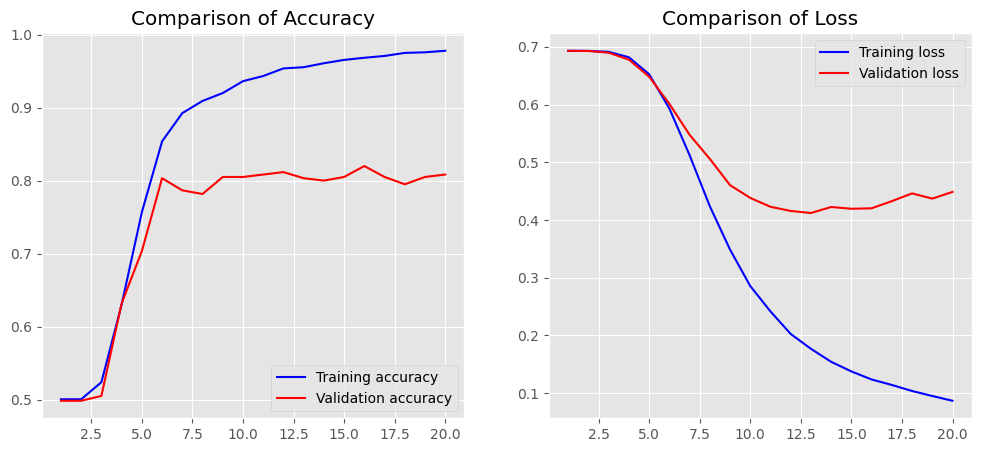

In [105]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Comparison of Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Comparison of Loss')
    plt.legend()

plot_history(history)

# the above code adapted from Janakiev (n.d.)

In [106]:
# Evaluate model
score = model.evaluate(test_reviews, test_labels)
score

19/19 [==============================] - 0s 2ms/step - loss: 0.4486 - accuracy: 0.8083


[0.44860103726387024, 0.8083333373069763]

In [202]:
#new model
new_model = tf.keras.Sequential([
tf.keras.layers.Embedding(input_dim=vocabulary_size,
                           output_dim = embed_dimension,
                           input_length=max_review)
, tf.keras.layers.GlobalAveragePooling1D()
, tf.keras.layers.Dense(4, activation='relu')
, tf.keras.layers.Dense(1, activation='sigmoid')
])

new_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
new_model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 41, 8)             38936     
                                                                 
 global_average_pooling1d_19  (None, 8)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_68 (Dense)            (None, 4)                 36        
                                                                 
 dense_69 (Dense)            (None, 1)                 5         
                                                                 
Total params: 38,977
Trainable params: 38,977
Non-trainable params: 0
_________________________________________________________________


# Part 4: Model Evaluation

## D.	Evaluate the model training process and its relevant outcomes by doing the following:

### 1.	Discuss the impact of using stopping criteria instead of defining the number of epochs, including a screenshot showing the final training epoch

As discussed above in C3, stopping criteria are utilized here in my "new_model." It was noted that the first model overfit, so early stopping criteria was incorporated into the new_model.fit() call. The method of monitoring the model was based on 'val_loss' and set to stop if there was 1 consecutive epoch of unchanging 'val_loss.' Utilizing this stopping criteria eliminates the need for us to manually review which epoch to cut the training at, but rather allows the model to do so independently when a specific stopping criteria is met (Elleh, 2022).

In [203]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=1)


new_history = new_model.fit(train_reviews, train_labels,
                    epochs=num_epochs, validation_data=(test_reviews, test_labels), callbacks=early_stopping)

Epoch 1/20
75/75 [==============================] - 1s 6ms/step - loss: 0.6930 - accuracy: 0.5004 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/20
75/75 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5717 - val_loss: 0.6899 - val_accuracy: 0.5917
Epoch 3/20
75/75 [==============================] - 0s 3ms/step - loss: 0.6858 - accuracy: 0.6525 - val_loss: 0.6853 - val_accuracy: 0.7683
Epoch 4/20
75/75 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.7904 - val_loss: 0.6777 - val_accuracy: 0.6350
Epoch 5/20
75/75 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.7725 - val_loss: 0.6644 - val_accuracy: 0.7683
Epoch 6/20
75/75 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.8167 - val_loss: 0.6457 - val_accuracy: 0.7917
Epoch 7/20
75/75 [==============================] - 0s 3ms/step - loss: 0.6020 - accuracy: 0.8704 - val_loss: 0.6213 - val_accuracy: 0.8050
Epoch 8/20
75/75 [==

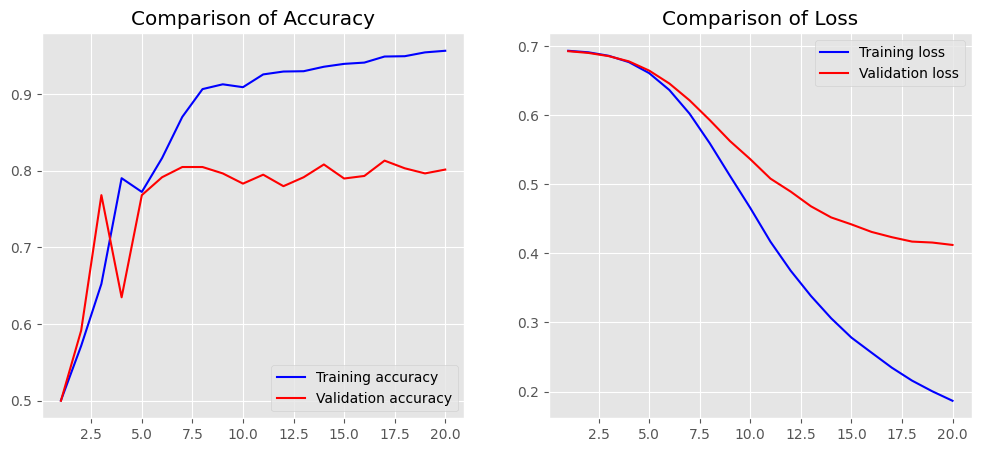

In [204]:
plt.style.use('ggplot')

plot_history(new_history)

## 2.	Provide visualizations of the model’s training process, including a line graph of the loss and chosen evaluation metric

This can be seen above for my "new_model", as well as above the header for Part 4 for my initial "model."

The graphs will vary slightly with each successive run, as the model changes slightly with each run.

## 3.	Assess the fitness of the model and any measures taken to address overfitting

The initial model that was made, discussed in part B, tended to overfit on the training data. It was seen with multiple successive runs that the model would attain >95% accuracy on the training data, then attain approximately 80% accuracy on the testing data.

To address this, the following steps were taken:
1. One of the hidden layers was removed from the "new_model."
2. Stopping criteria was incorporated into the "new_model."

It is still noted that occasionally there will be overfitting or underfitting with the new model, but often the model will end up stopping near epoch 14 or 15 after hitting the stopping criteria.

In [205]:
# Evaluate model
new_score = new_model.evaluate(test_reviews, test_labels)
new_score

19/19 [==============================] - 0s 2ms/step - loss: 0.4122 - accuracy: 0.8017


[0.41216912865638733, 0.8016666769981384]

## 4.	Discuss the predictive accuracy of the trained network

The "new_model" even with stopping criteria will sometimes run through the full 20 epochs. At the time of writing this, the most recent run had an accuracy of 80%, similar to the initial model. The final epoch output will be pasted below for clarity:
<br>Epoch 20/20
<br>75/75 [==============================] - 0s 4ms/step - loss: 0.1868 - accuracy: 0.9567 <br>- val_loss: 0.4122 - val_accuracy: 0.8017

It can be seen that once again the model hit >95% accuracy on the training data, and near 80% on the testing data. This is a moderately accurate model, but could likely still use more fine tuning to decrease overfitting further.

# Part 5: Summary and Recommendations

## E.	Provide the code used to save the trained network within the neural network





In [207]:
model.save('SentimentAnalysisModelOne.h5')
new_model.save('SentimentAnalysisModelTwo.h5')

## F.	Discuss the functionality of your neural network, including the impact of the network architecture

Overall, the creation of this neural network model has completed what I set out to do. My goal for this task was to cr to create a model that predicts, with moderate accuracy, the sentiment of a review. This was accomplished via both a model with 5 layers (embedding, flattening, hidden, hidden, output), and a model with 4 layers (embedding, flattening, hidden, output) and a stopping criteria.


## G.	Recommend a course of action based on your results

I would recommend that the next course of action be along the following lines:
*   Create multiple new models, each with the purpose of predicting sentiment based on only one of the 3 initial datasets rather than creating a model for all 3 combined. This may allow each model to more accurately label sentiment, due to all of the included reviews would be more similar in nature, i.e. comparing only movie reviews against movie reviews, rather than movie reviews against product reviews.

# Part 6: Reporting

## H.	Create your neural network using an industry-relevant interactive development environment (e.g. a Jupyter Notebook). Include a PDF or HTML document of your executed notebook presentation.

Please see the attached notebook and html file.

## I. List the web sources used to acquire data or segments of third-party code to support the application.

1.   Agarwal, R. (2019, July 1). Apply and Lambda usage in pandas. TowardsDataScience. Retrieved July 1, 2023, from https://towardsdatascience.com/apply-and-lambda-usage-in-pandas-b13a1ea037f7
2.   Elleh, F. (2022, May 15). D213 T2 May 15 22 [Online video lecture]. Western Governors University. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=cedbd86a-2543-4d9d-9b0e-aec4011a606d
3.   Janakiev, N. (n.d.). Practical Text Classification With Python and Keras. Real Python. Retrieved July 1, 2023, from https://realpython.com/python-keras-text-classification/

## J. Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.

1.   C. (2020, April 2). Hands-on TensorFlow Tokenizer for NLP. TowardsDataScience. Retrieved July 1, 2023, from https://medium.com/@canerkilinc/hands-on-tensorflow-tokenizer-for-nlp-392c97d5874d
2.   C. (2020, April 2). Padding for NLP. TowardsDataScience. Retrieved July 1, 2023, from https://medium.com/@canerkilinc/padding-for-nlp-7dd8598c916a
3.   Elleh, F. (2022, May 15). D213 T2 May 15 22 [Online video lecture]. Western Governors University. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=cedbd86a-2543-4d9d-9b0e-aec4011a606d
4.   Nasrin Sucky, R. (2021, July 8). A Complete Step by Step Tutorial on Sentiment Analysis in Keras and Tensorflow. TowardsDataScience. Retrieved July 1, 2023, from https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f
5.   Pai, A. (2020, February 12). CNN vs. RNN vs. ANN – Analyzing 3 Types of Neural Networks in Deep Learning. Analytics Vidhya. Retrieved July 1, 2023, from https://www.analyticsvidhya.com/blog/2020/02/cnn-vs-rnn-vs-mlp-analyzing-3-types-of-neural-networks-in-deep-learning/
6.   Singh Sachdev, H. (2020, January 23). Choosing number of Hidden Layers and number of hidden neurons in Neural Networks. LinkedIn. Retrieved July 1, 2023, from https://www.linkedin.com/pulse/choosing-number-hidden-layers-neurons-neural-networks-sachdev/


## K. Demonstrate professional communication in the content and presentation of your submission.